In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [9]:
program.train(dataset_params = {
    #'from': '2013-05-10'
    'from': '2016-01-02',
    'to': '2018-10-01',
    'sub_categories': ['AUTOSTART']
})

preparing model data
training knn_10
mea: 1.5303583735354929
training knn_100
mea: 1.5716280934778524
training mlp_10
mea: 1.6128665352541967
training mlp_100
mea: 1.6060586052828363
training gbr_10
mea: 1.6229717363313112
training gbr_100
mea: 1.6920220819191547
training rf_10
mea: 2.072083860660359
training rf_100
mea: 2.0669109882421735
training knn_10
mea: 1.5666424363955385
training knn_100
mea: 1.563989911016418
training mlp_10
mea: 1.5385930059107003
training mlp_100
mea: 1.6007597614784048
training gbr_10
mea: 1.5470039651395269
training gbr_100
mea: 1.562180555165344
training rf_10
mea: 1.898550409109627
training rf_100
mea: 1.873811267026341


In [10]:
program.dataset.save()
print(program.dataset.hash)
program.model.save()
print(program.model.hash)

b69086f9bc5dedda9328fbb51771d771
8948b3ec9f8d1a9f09e4610a770ae0f9


In [11]:
print('{} races from {} to {}'.format(program.df.race_id.nunique(), program.df.start_at.min(), program.df.start_at.max()))

2553 races from 2016-01-02 16:10:00 to 2018-07-31 22:19:00


In [12]:
import pandas as pd
from cataclop.ml import preprocessing

for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")


gbr_10
victory_count_r                 0.279538
placed_3_count_r                0.146938
prev_year_earnings_amin         0.073683
prev_year_earnings_amax         0.071432
victory_earnings_amax           0.070803
hist_4_pos                      0.054699
placed_2_count_r                0.051845
victory_count_amin              0.033101
race_count_r                    0.026127
prev_year_earnings              0.024045
odds_7                          0.021974
odds_8                          0.020290
race_count_std                  0.017646
placed_2_count_std              0.017038
victory_count_mean              0.016063
odds_9                          0.012821
hist_1_pos                      0.011621
placed_3_count_amax             0.010138
hist_5_pos                      0.010107
placed_earnings_std             0.008801
placed_earnings_r               0.006220
odds_0                          0.004831
placed_earnings_amax            0.004105
victory_earnings_r              0.003181
odds_1   

In [13]:
program.bet(N=1, max_odds=20)
bets = program.bets
bets['profit'].describe()

count    11682.000000
mean        -0.188855
std          2.878123
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max         50.100000
Name: profit, dtype: float64

In [18]:
bets = bets.reset_index(drop=True)

---
AUTOSTART	+57.60	+1554.00	+1554.00
---
pred_gbr_100_1: 	 +40.00 	 +831 	 +0.05
pred_gbr_10_1: 	 +23.60 	 +717 	 +0.03


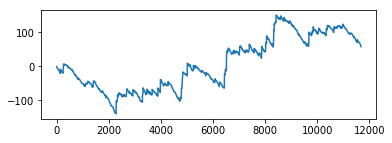

In [21]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

#bb = bets.groupby('id').filter(lambda r: r['num'].nunique() == 1 ).copy()
bb = bets[(bets['target'].str.contains('^pred_gbr')) ].groupby('id').filter(lambda r: r['num'].nunique() == 1 ).copy()
#bb = bets[(bets['target'].str.contains('^pred_mlp')) & (bets['pred_stacked_1']>1)].groupby('id').filter(lambda r: r['num'].nunique() == 1 ).copy()
#bb = bets.groupby('id').filter(lambda r: (r['target'] == 'pred_mlp_1').sum() == 0 and (r['target'] == 'pred_knn_10_1').sum() == 1  )

def f(r):
    n1 = r[(r['target'] == 'pred_mlp_100_1')]['num']
    n2 = r[(r['target'] == 'pred_rf_100_1')]['num']
    
    if not len(n1) and len(n2):
        return True
    if not len(n2) and len(n1):
        return True
    
    if n1.max() != n2.max():
        return True
    
    return False

#bb = bets.groupby('id').filter(f)

f = 'sub_category'

for s in bb[f].value_counts().index:
    x = bb[bb[f] == s].copy()
    print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))
    for t in x['target'].value_counts().index:
        bbb = x[(x['target'] == t) & (x['odds_ref'] < 20)].copy()
        print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )
        
    x['stash'] = x['profit'].cumsum()

    fig, axs = plt.subplots(1,1)
    x['stash'].plot(figsize=(6, 2))
    plt.show()

In [22]:
import numpy as np
from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge

groups = bets['id'].values
group_kfold = GroupKFold(n_splits=2)
splits = list(group_kfold.split(bets.values, bets.profit.values, groups))

targets = ['pred_{}_1'.format(model['name']) for model in program.model.models]

features = []

for target in targets:
    bets[target] = (bets['target'] == target).astype(np.float)
    bets['pred_{}'.format(target)] = 0
    features.append(target)
    features.append('pred_{}'.format(target))
    
cats = program.df['sub_category'].value_counts()[0:5].index

for cat in cats:
    bets['cat_{}'.format(cat)] = (bets['sub_category'] == cat).astype(np.float)
    features.append('cat_{}'.format(cat))

bets['pred_stacked_1'] = 0.

races = bets.groupby('id')

for (id, race) in races:
    for target in targets:
        bets.loc[race.index, 'pred_{}'.format(target)] = race[ race['target'] == target ]['pred'].max()

features += ['pred']

bets.fillna(0, inplace=True)

for train_index, test_index in splits:
    
    X_train = bets[features].iloc[train_index].copy()
    y_train = bets['profit'].iloc[train_index]
    
    #print(X_train.describe())
    
    X_test = bets[features].iloc[test_index].copy()
    y_test = bets['profit'].iloc[test_index]
    
    idx = bets.iloc[test_index].index
    
    estimator = RandomForestRegressor(n_estimators=10, random_state=1234)
    estimator.fit(X_train.values, y_train.values)
    
    print(p.shape)
    p = estimator.predict(X_test.values)
    bets.loc[test_index, 'pred_stacked_1'] = p




(6897,)


KeyError: '[   27    43    44 ... 13790 13791 13792] not in index'

In [20]:
len(idx)

6897

In [9]:
import pandas as pd
from cataclop.ml import preprocessing

fi = pd.Series(estimator.feature_importances_, index=features)
print(fi.sort_values(ascending=False)[0:100])
print("---\n")


NameError: name 'estimator' is not defined

In [13]:
bets[bets['pred_stacked_1'] < 1]['profit'].describe()

count    48799.000000
mean        -0.224650
std          3.234828
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max         77.200000
Name: profit, dtype: float64

In [14]:
bets[bets['profit'] < 1]['pred_stacked_1'].describe()

count    49000.000000
mean        -0.019183
std          0.957023
min         -1.000000
25%         -0.589000
50%         -0.235000
75%          0.276000
max         43.221000
Name: pred_stacked_1, dtype: float64

In [15]:
bets[features][0:10]

,pred_knn_10_1,pred_pred_knn_10_1,pred_knn_100_1,pred_pred_knn_100_1,pred_mlp_10_1,pred_pred_mlp_10_1,pred_mlp_100_1,pred_pred_mlp_100_1,pred_gbr_10_1,pred_pred_gbr_10_1,pred_gbr_100_1,pred_pred_gbr_100_1,pred_rf_10_1,pred_pred_rf_10_1,pred_rf_100_1,pred_pred_rf_100_1,cat_COURSE_A_CONDITIONS,cat_AUTOSTART,cat_HANDICAP,cat_HANDICAP_DIVISE,cat_A_RECLAMER,pred
0,0.0,1.98,0.0,1.800,0.0,2.805877,1.0,2.137442,0.0,3.213897,0.0,0.000000,0.0,2.90,0.0,2.280,0.0,0.0,0.0,0.0,1.0,2.137442
1,0.0,3.33,1.0,2.702,0.0,4.114505,0.0,3.023920,0.0,0.000000,0.0,0.000000,0.0,5.75,0.0,0.000,0.0,1.0,0.0,0.0,0.0,2.702000
2,1.0,3.33,0.0,2.702,0.0,4.114505,0.0,3.023920,0.0,0.000000,0.0,0.000000,0.0,5.75,0.0,0.000,0.0,1.0,0.0,0.0,0.0,3.330000
3,0.0,0.00,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,5.148131,1.0,6.562568,0.0,0.00,0.0,0.000,0.0,1.0,0.0,0.0,0.0,6.562568
4,0.0,0.00,0.0,0.000,0.0,0.000000,0.0,0.000000,1.0,5.148131,0.0,6.562568,0.0,0.00,0.0,0.000,0.0,1.0,0.0,0.0,0.0,5.148131
5,0.0,0.00,0.0,5.773,0.0,3.892718,0.0,4.051029,0.0,0.000000,0.0,0.000000,0.0,0.00,1.0,8.396,0.0,1.0,0.0,0.0,0.0,8.396000
6,0.0,0.00,0.0,5.773,0.0,3.892718,1.0,4.051029,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,8.396,0.0,1.0,0.0,0.0,0.0,4.051029
7,0.0,0.00,0.0,5.773,1.0,3.892718,0.0,4.051029,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,8.396,0.0,1.0,0.0,0.0,0.0,3.892718
8,0.0,0.00,1.0,5.773,0.0,3.892718,0.0,4.051029,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,8.396,0.0,1.0,0.0,0.0,0.0,5.773000
9,0.0,11.28,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,7.72,0.0,0.000,0.0,1.0,0.0,0.0,0.0,7.720000
